In [226]:
%matplotlib inline
from matplotlib import pyplot as plt
import torch
import skorch
from skorch.helper import predefined_split
from skorch.dataset import Dataset

In [198]:
from functools import partial

In [199]:
import numpy as np

In [200]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

In [201]:
from deepspeech.model import DeepSpeech
from deepspeech.model import SequenceWise
from deepspeech.data.data_loader import SpectrogramParser
from deepspeech.data.data_loader import BucketingSampler

In [202]:
from data import dataset
from utils import RNNValueExtractor
from utils import Identity
from utils import bucketing_dataloader
from utils import filter_low_count_words
from layers import ResidualRNN

In [203]:
base_model = DeepSpeech.load_model(
    'models/librispeech_pretrained.pth'
)
audio_conf = DeepSpeech.get_audio_conf(base_model)
parser = SpectrogramParser(audio_conf)

In [204]:
ds_swear = dataset.SwearDataset(dataset.DEFAULT_PROVIDERS)

In [205]:
X_swear, y_swear = ds_swear.load()

In [206]:
ds = dataset.SwearBinaryAudioDataset(X_swear, y_swear, parser)

In [207]:
X, y = ds.load()

In [208]:
seq_lens = np.array([x.shape[1] for x in X])
max_seq_len = max(seq_lens)
max_seq_len, np.mean(seq_lens), np.median(seq_lens)

(663, 233.85714285714286, 173.0)

In [209]:
X_pad = np.zeros(
    (len(X), X[0].shape[0], max_seq_len), 
    dtype='float32'
)
for i, _ in enumerate(X):
    X_pad[i, :, :seq_lens[i]] = X[i]
    
y = np.array(y)

Filter low count words

In [210]:
idcs = filter_low_count_words(X_swear, min_count=4)
X_pad = X_pad[idcs]
y = y[idcs]

In [211]:
split = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [212]:
# use word as class for stratified split to make sure that train/test
# set both contain examples of the all words.
y_word = np.array([n[0] for n in X_swear])[idcs]
train_idcs_proto, test_idcs = next(split.split(y, y=y_word))

/data/tietz/envs/noswear/lib/python3.5/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


In [213]:
train_idcs, valid_idcs = next(split.split(y[train_idcs_proto], y=y_word[train_idcs_proto]))

/data/tietz/envs/noswear/lib/python3.5/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


In [214]:
train_idcs = train_idcs_proto[train_idcs]
valid_idcs = train_idcs_proto[valid_idcs]

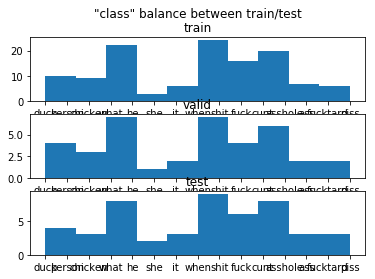

In [215]:
plt.subplot(311)
plt.title('"class" balance between train/test\ntrain')
plt.hist(y_word[train_idcs]);
plt.subplot(312)
plt.title('valid')
plt.hist(y_word[valid_idcs]);
plt.subplot(313)
plt.title('test')
plt.hist(y_word[test_idcs]);

In [216]:
X_train = {'lens': seq_lens[train_idcs], 'X': X_pad[train_idcs]}
y_train = np.array(y)[train_idcs]

X_valid = {'lens': seq_lens[valid_idcs], 'X': X_pad[valid_idcs]}
y_valid = np.array(y)[valid_idcs]

X_test = {'lens': seq_lens[test_idcs], 'X': X_pad[test_idcs]}
y_test = np.array(y)[test_idcs]

In [218]:
len(X_train['X']), len(X_valid['X']), len(X_test['X'])

(123, 38, 49)

In [223]:
class NoSwearModel(torch.nn.Module):
    def __init__(
        self, 
        base_model, 
        n_hidden=10, 
        n_layer=1,
        p_dropout=0.2
    ):
        super().__init__()
        self.base_model = base_model
        self.base_model.rnns = Identity()
        self.base_model.lookahead = Identity()
        self.base_model.fc = Identity()
        self.base_model.inference_softmax = Identity()
        
        self.rnn = torch.nn.Sequential(
            torch.nn.GRU(672, n_hidden, num_layers=n_layer, bias=False, batch_first=True),
            RNNValueExtractor(),
        )

        self.clf = torch.nn.Linear(n_hidden, 2, bias=False)
        self.dropout = torch.nn.Dropout(p=p_dropout)
        
    def forward(self, X, lens):
        # run base model, output is NxTxH with
        # T=Time, N=samples, H=hidden.
        y_pre = self.base_model(X)
        y_pre = self.dropout(y_pre)
        
        # run RNN over sequence and extract last item
        y = self.rnn(y_pre)
        # presumably we cannot use lens since cnns reduce that too
        #y = y[:, lens - 1]
        #y = y[:, -1]
        i = y.mean(-1).argmax(1)
        y = y[torch.arange(len(y)), i]
        
        y = self.dropout(y)
        
        # run classifier
        y = self.clf(y)
        y = torch.softmax(y, dim=-1)
        return y

In [224]:
def bucket(Xi, yi):
    Xi['X'] = Xi['X'][:, :, :max(Xi['lens'])]
    return Xi, yi

In [256]:
torch.manual_seed(42)

net = skorch.NeuralNetClassifier(
    partial(NoSwearModel, base_model), 
    
    iterator_train=bucketing_dataloader,
    iterator_train__bucket_fn=bucket,
    iterator_valid=bucketing_dataloader,
    iterator_valid__bucket_fn=bucket,
    
    batch_size=64,
    max_epochs=40,
    device='cuda',
    
    train_split=predefined_split(Dataset(X_valid, y_valid)),
    
    module__p_dropout=0.2,
    module__n_hidden=300,
        
    optimizer=torch.optim.Adam,
    optimizer__lr=0.0004,
    #optimizer__weight_decay=1e-4,
    
    callbacks=[
        skorch.callbacks.Freezer('base_model.*'),
        #skorch.callbacks.Checkpoint(monitor='valid_acc_best'),
        #skorch.callbacks.TrainEndCheckpoint(),
    ]
)

In [245]:
%pdb on
net.fit(X_train, y_train)

Automatic pdb calling has been turned ON
  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
      1        0.9890       0.5000        0.7355     +  0.2529
      2        0.7623       0.5263        0.7023     +  0.2549
      3        0.6927       0.5263        0.7195        0.2552
      4        0.6722       0.5000        0.7645        0.2544
      5        0.7062       0.5000        0.7878        0.2545
      6        0.6926       0.5000        0.7748        0.2544
      7        0.6867       0.5526        0.7576     +  0.2532
      8        0.7088       0.6053        0.7238     +  0.2532
      9        0.7010       0.6053        0.6981        0.2520
     10        0.6377       0.6053        0.6762        0.2544
     11        0.6497       0.6579        0.6661     +  0.2544
     12        0.6116       0.6842        0.6583     +  0.2566
     13        0.6287       0.6579        0.6600        0.2538
     14       

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=NoSwearModel(
    (base_model): DeepSpeech(
      (conv): Sequential(
        (0): Conv2d(1, 32, kernel_size=(41, 11), stride=(2, 2), padding=(0, 10))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=0, max_val=20, inplace)
        (3): Conv2d(32, 32, kernel_size=(21, 11), stride=(2, 1))
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): Hardtanh(min_val=0, max_val=20, inplace)
      )
      (rnns): Identity()
      (fc): Identity()
      (inference_softmax): Identity()
      (lookahead): Identity()
    )
    (rnn): Sequential(
      (0): GRU(672, 300, bias=False, batch_first=True)
      (1): RNNValueExtractor()
    )
    (clf): Linear(in_features=300, out_features=2, bias=False)
    (dropout): Dropout(p=0.2)
  ),
)

In [249]:
#net.load_params(checkpoint=dict(net.callbacks_)['Checkpoint'])
#net.load_params(checkpoint=dict(net.callbacks_)['TrainEndCheckpoint'])

In [250]:
accuracy_score(y_test, net.predict(X_test))

0.7142857142857143

In [257]:
from sklearn.model_selection import GridSearchCV
from skorch.helper import SliceDict

In [258]:
#net.initialize();
net.set_params(verbose=False);

In [259]:
params = {
    'optimizer__lr': [0.02, 0.002, 0.0002],
    'optimizer__weight_decay': [0, 1e-4],
    'optimizer': [torch.optim.RMSprop, torch.optim.Adam],
    'module__p_dropout': [0, 0.5],
    'module__n_hidden': [10, 100, 200, 400],
    'module__n_layer': [1, 2],
}

In [260]:
gs = GridSearchCV(net, params, scoring='accuracy')

In [ ]:
%%time
gs.fit(SliceDict(**X_train), y_train);

In [ ]:
import pandas as pd
results = pd.DataFrame(gs.cv_results_)

In [ ]:
results.sort_values(by='mean_test_score').head(10)

In [ ]:
net.set_params(verbose=True, **gs.best_params_);

In [ ]:
net.fit(X_train, y_train);

In [ ]:
accuracy_score(y_test, net.predict(X_test))